# Annalyse non supervisée

## Chargement des features

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

df_features = pd.read_parquet("../data/brain_features_resnet50.parquet")
df_features.head()

,filepath,has_label,label,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,label_num
0,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.011641,0.014855,0.309468,0.112984,0.092031,0.000000,0.443308,...,0.050269,0.062702,0.118318,0.034898,0.199230,1.656034,0.041210,0.073140,0.369943,1
1,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.047576,0.045124,0.004747,0.000000,0.000000,0.000000,0.003254,...,0.000000,0.123328,0.000000,0.027098,0.290650,0.242351,0.000000,0.000000,0.000000,1
2,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.023101,0.067208,0.135242,0.000000,0.000000,0.000375,0.203493,...,0.007180,0.127119,0.000000,0.102672,0.980460,0.702292,0.000000,0.000000,0.000000,1
3,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.003039,0.192276,0.042327,0.000000,0.004168,0.000000,1.024806,...,0.069563,0.017233,0.060294,0.020966,0.134899,0.357556,0.000686,0.011123,0.063624,1
4,..\data\mri_dataset_brain_cancer_oc\avec_label...,True,cancer,0.151541,0.046058,0.109404,0.000000,0.026315,0.008330,0.357026,...,0.091114,0.005454,0.010853,0.042849,0.361198,0.324573,0.012139,0.001569,0.194653,1


### Récupération des colonnes de features

In [13]:
feature_cols = [c for c in df_features.columns if c.startswith("f_")]
X = df_features[feature_cols].values  # shape (1500, 2048)

print(X.shape)

(1506, 2048)


## Standardisation & PCA

In [15]:
# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA pour réduire à 50 dims (KMeans + visualisation)
pca_50 = PCA(n_components=50, random_state=42)
X_pca50 = pca_50.fit_transform(X_scaled)

print("Variance expliquée (50 comps) :", pca_50.explained_variance_ratio_.sum())

Variance expliquée (50 comps) : 0.4646427


La PCA à 50 composantes conserve environ 46%

## KMeans (clustering principal)

### Essai de plusieurs valeurs de k

C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

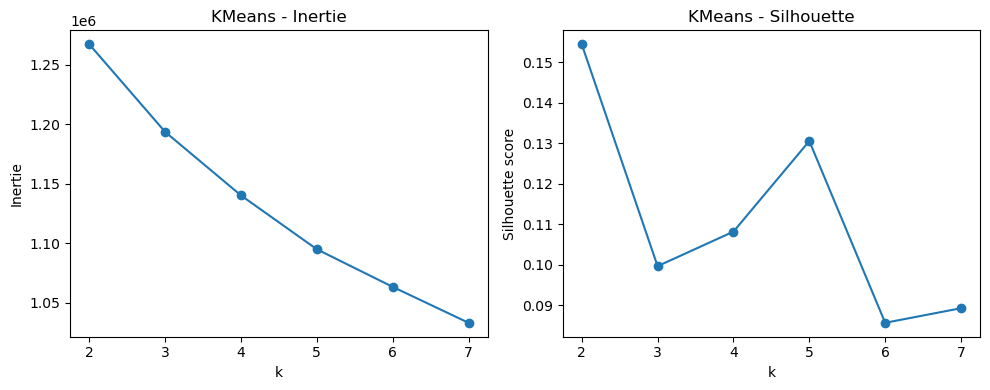

In [19]:
inertias = []
sil_scores = []
K_RANGE = range(2, 8)

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans.fit_predict(X_pca50)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_pca50, labels_k))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(K_RANGE), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertie")
plt.title("KMeans - Inertie")

plt.subplot(1,2,2)
plt.plot(list(K_RANGE), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("KMeans - Silhouette")
plt.tight_layout()
plt.show()

### Fit final avec k choisi

In [21]:
K = 2
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca50)

df_features["cluster_kmeans"] = clusters
df_features["cluster_kmeans"].value_counts()

C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


cluster_kmeans
0    848
1    658
Name: count, dtype: int64

## Visualisation 2D

### PCA à 2 composants pour les scatters plots

In [24]:
pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X_scaled)

df_features["pc1"] = X_pca2[:,0]
df_features["pc2"] = X_pca2[:,1]

### Scatter coloré par cluster

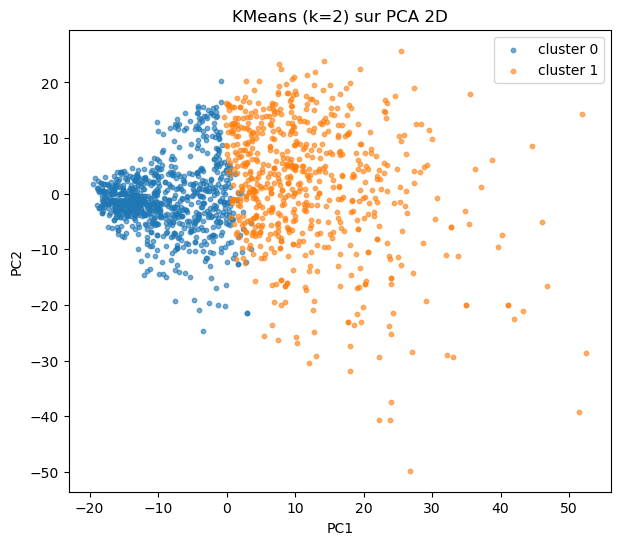

In [26]:
plt.figure(figsize=(7,6))
for c in sorted(df_features["cluster_kmeans"].unique()):
    subset = df_features[df_features["cluster_kmeans"] == c]
    plt.scatter(subset["pc1"], subset["pc2"], s=10, alpha=0.6, label=f"cluster {c}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans (k=2) sur PCA 2D")
plt.legend()
plt.show()

### Scatter coloré par label (images annotées)

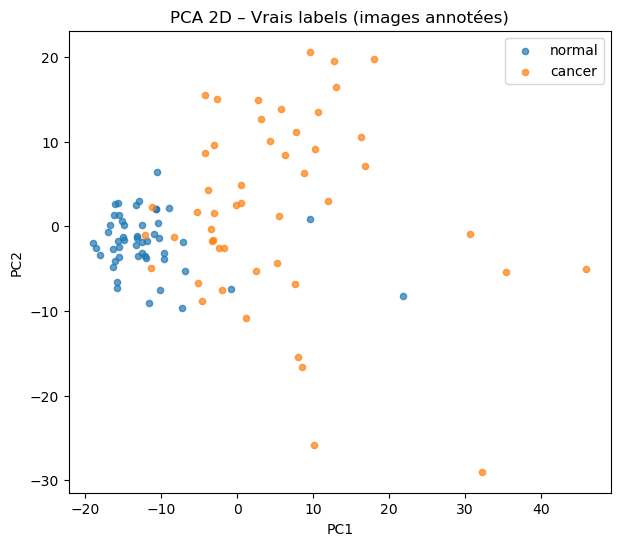

In [28]:
labeled = df_features[df_features["label"].notna()]

plt.figure(figsize=(7,6))
for lab in ["normal", "cancer"]:
    subset = labeled[labeled["label"] == lab]
    plt.scatter(subset["pc1"], subset["pc2"], s=20, alpha=0.7, label=lab)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D – Vrais labels (images annotées)")
plt.legend()
plt.show()

## Evaluation des clusters avec les labels connus

Evaluation du KMeans sur sous-ensemble

In [31]:
labeled = df_features[df_features["label"].notna()].copy()

y_true = labeled["label"].map({"normal": 0, "cancer": 1}).values
y_cluster = labeled["cluster_kmeans"].values

print("ARI :", adjusted_rand_score(y_true, y_cluster))
print("NMI :", normalized_mutual_info_score(y_true, y_cluster))
print("Silhouette (global) :", silhouette_score(X_pca50, df_features["cluster_kmeans"]))

ARI : 0.24370826390048933
NMI : 0.2674405643726493
Silhouette (global) : 0.15439895


Matrice de confusion

In [33]:
cm = confusion_matrix(y_true, y_cluster)
cm

array([[48,  2],
       [23, 27]], dtype=int64)

In [34]:
# afficher avec seaborn

## Test d'un autres modèle de clustering

In [36]:
dbscan = DBSCAN(eps=1.5, min_samples=10)
clusters_db = dbscan.fit_predict(X_pca50)

df_features["cluster_dbscan"] = clusters_db
df_features["cluster_dbscan"].value_counts()

cluster_dbscan
-1    1506
Name: count, dtype: int64

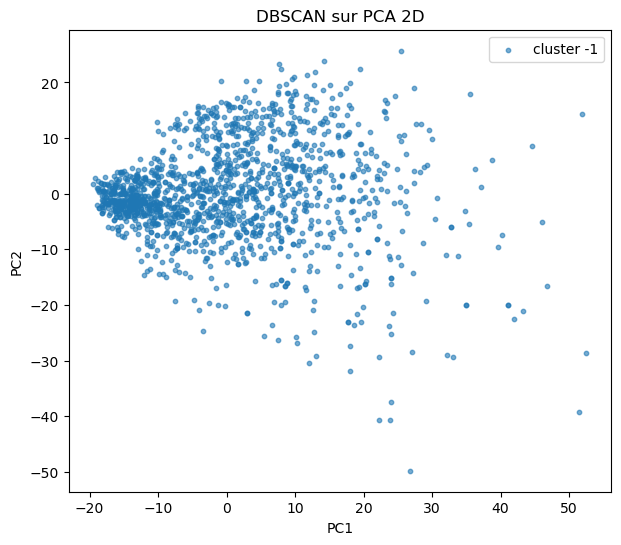

In [37]:
plt.figure(figsize=(7,6))
for c in sorted(df_features["cluster_dbscan"].unique()):
    subset = df_features[df_features["cluster_dbscan"] == c]
    plt.scatter(subset["pc1"], subset["pc2"], s=10, alpha=0.6, label=f"cluster {c}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN sur PCA 2D")
plt.legend()
plt.show()

## Construction du jeu de données faiblement labellisé

L'objectif final de cette partie est de créer un ensemble d’images **faiblement labellisées** à partir du clustering non supervisé.  
Cet ensemble sera utilisé dans l’étape suivante (apprentissage semi-supervisé), conformément aux consignes du projet.

1. Nous disposons uniquement de **100 images annotées** (normal / cancer).
2. Nous avons appliqué un clustering **K-Means (k = 2)** sur les embeddings extraits par ResNet50.
3. En utilisant les **images annotées**, nous pouvons déterminer pour chaque cluster le label dominant (via la matrice de confusion).
4. Nous utilisons cette correspondance pour attribuer un **pseudo-label** aux images non annotées.

Ce processus produit un dataset dit **faiblement labellisé**, car les labels proviennent d’un algorithme non supervisé et sont donc potentiellement bruités.

Selon les consignes du projet, ce dataset doit être **conservé séparément** du dataset fortement labellisé.

### Détermination du mapping cluster > label

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Données annotées uniquement
labeled = df_features[df_features["has_label"]].copy()
y_true = labeled["label"].map({"normal": 0, "cancer": 1}).values
y_cluster = labeled["cluster_kmeans"].values

# Matrice de confusion cluster vs vrais labels
cm = confusion_matrix(y_true, y_cluster)
cm


array([[48,  2],
       [23, 27]], dtype=int64)

In [43]:
cluster_to_label = {}
for cluster in [0, 1]:
    # colonne = distribution des labels réels pour un cluster donné
    majority_label = np.argmax(cm[:, cluster])
    cluster_to_label[cluster] = majority_label

cluster_to_label


{0: 0, 1: 1}

### Construction du jeu faiblement labellisé

In [45]:
# Images non annotées
df_unlabeled = df_features[df_features["has_label"] == False].copy()

# Ajout du pseudo-label numérique
df_unlabeled["weak_label_num"] = df_unlabeled["cluster_kmeans"].map(cluster_to_label)

# Ajout du pseudo-label texte
inv_map = {0: "normal", 1: "cancer"}
df_unlabeled["weak_label"] = df_unlabeled["weak_label_num"].map(inv_map)

df_unlabeled.head()

,filepath,has_label,label,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_2045,f_2046,f_2047,label_num,cluster_kmeans,pc1,pc2,cluster_dbscan,weak_label_num,weak_label
100,..\data\mri_dataset_brain_cancer_oc\sans_label...,False,None,0.000000,0.032982,0.029727,0.005724,0.000000,0.001122,0.396253,...,0.000000,0.006705,0.105339,-1,1,11.727874,6.908487,-1,1,cancer
101,..\data\mri_dataset_brain_cancer_oc\sans_label...,False,None,0.007041,0.001747,0.021182,0.000000,0.019327,0.000000,0.207386,...,0.012702,0.080563,0.000000,-1,0,-2.846513,0.496893,-1,0,normal
102,..\data\mri_dataset_brain_cancer_oc\sans_label...,False,None,0.023832,0.007033,0.166738,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.036756,0.000000,-1,0,-13.715561,-1.209869,-1,0,normal
103,..\data\mri_dataset_brain_cancer_oc\sans_label...,False,None,0.028333,0.000000,0.066101,0.000000,0.026202,0.000000,0.535859,...,0.027819,0.000000,0.162083,-1,0,-4.233032,-1.537029,-1,0,normal
104,..\data\mri_dataset_brain_cancer_oc\sans_label...,False,None,0.000000,0.203467,0.394194,0.000000,0.000000,0.024501,0.376836,...,0.000000,0.000000,0.051782,-1,1,16.564928,-5.144204,-1,1,cancer


### Sauvegarde du dxataset faible

In [47]:
df_unlabeled[["filepath", "weak_label_num", "weak_label"]].to_parquet(
    "../data/brain_weak_labels_kmeans.parquet",
    index=False
)

### Résultat

Nous avons maintenant un dataset contenant toutes les images non annotées accompagnées de labels issus du clustering.  
Ce nouveau fichier (`brain_weak_labels_kmeans.parquet`) constitue notre **jeu faiblement labellisé**.

Il sera utilisé dans le prochain notebook pour entraîner un modèle CNN en mode **semi-supervisé**, selon le protocole demandé : 
1. entraînement sur le jeu faiblement labellisé,
2. puis entraînement sur le jeu fortement labellisé.


Conclusion – Analyse non supervisée

Dans ce notebook, j’ai appliqué des méthodes d’analyse non supervisée afin d’explorer la structure latente du dataset à partir des embeddings extraits par ResNet50 pré-entraîné.

1. Préparation des données

Les 2048 features générées pour chaque image ont été :

standardisées,

réduites par PCA (50 composantes, ~46 % de variance préservée),

projetées en 2D pour visualisation.

Ces étapes permettent de travailler dans un espace plus compact tout en conservant les structures importantes.

2. Clustering KMeans

Plusieurs valeurs de k ont été testées :

L’inertie décroît régulièrement, comme attendu.

Le Silhouette Score atteint un maximum autour de k = 3, mais k=2 reste pertinent pour comparer avec les labels normal/cancer.

Le clustering final avec k = 2 fournit une séparation imparfaite mais réelle :

Les clusters identifiés en PCA2D montrent deux groupes visuellement distincts.

La répartition des 1500 images est relativement équilibrée.

3. Évaluation avec les labels connus

Sur les 100 images annotées :

ARI ≈ 0.24

NMI ≈ 0.26

Silhouette global ≈ 0.15

Ces scores indiquent que les embeddings ResNet50 capturent une partie de la structure liée aux labels (normal vs cancer), mais pas suffisamment pour une classification directe.

Cela confirme que le clustering seul ne permet pas une séparation nette des classes, ce qui est cohérent avec la difficulté du problème (IRM, forte variabilité inter-patient).

4. Test d’un second algorithme : DBSCAN

DBSCAN ne détecte aucun cluster exploitable (tous les points classés -1).
Cela confirme que :

les clusters ne sont pas suffisamment denses,

la structure n’est pas linéairement séparable en haute dimension.

Conclusion générale

L’analyse non supervisée montre que :

les embeddings ResNet50 contiennent bien une structure informative,

mais cette structure reste partiellement corrélée aux labels médicaux,

les données ne se séparent pas naturellement en deux groupes homogènes.

Ces observations justifient pleinement l'étape suivante :
 Mettre en œuvre une approche d’apprentissage semi-supervisé, capable d’exploiter simultanément les 100 images annotées et les ~1400 non annotées.